# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -U langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

  Using cached langchain_openai-0.2.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached langchain_community-0.3.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached langchain-0.3.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached PyMuPDF-1.24.10-cp312-none-win_amd64.whl.metadata (3.4 kB)
  Using cached qdrant_client-1.11.2-py3-none-any.whl.metadata (10 kB)
  Using cached langchain_qdrant-0.1.4-py3-none-any.whl.metadata (1.7 kB)
  Using cached langchain_core-0.3.7-py3-none-any.whl.metadata (6.3 kB)
  Using cached tiktoken-0.7.0-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached SQLAlchemy-2.0.35-cp312-cp312-win_amd64.whl.metadata (9.9 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
  Using cached pydantic_settings-2.5.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata 


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


We'll need an OpenAI API Key:

In [2]:
import os
# import getpass

# os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

And the LangSmith set-up:

In [2]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

Let's verify our project so we can leverage it in LangSmith later.

In [3]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - 78975309


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [7]:
from google.colab import files
uploaded = files.upload()

Saving eu_ai_act.html to eu_ai_act (1).html


In [25]:
file_path = list(uploaded.keys())[0]
file_path

'eu_ai_act (1).html'

We'll define our chunking strategy.

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [5]:
file_path = "data/anema.pdf"

In [6]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [3]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import AzureOpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = AzureOpenAIEmbeddings(azure_deployment="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

NameError: name 'uuid' is not defined

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

#### ✔️ Answer #1:

- This works well when we have a smaller set of questions. If we have a RAG over a large dataset, than we may get millions of different questions that rarely repeat.
- The same question can be formed in many different ways. If we just check the exact match, we won't be able to match if a question is formed in a different way or there was a spelling error or extra whitespace.
- Matching by exact vector would not work too, however, we could determine a threshold for matching.
- Another reason it would fail to work if an LLM Agent was use to rephrase user query (for instance, if we persist chat history and agent needs to understand from the context what a user is enqueyering). LLM introduces variance and the same question can be queried in different ways.
- If for search we also used metadata, like say filtering by authors, keywords, etc. It would not be captured in the query itself.
- I believe it could work for questions similar to FAQ, like a contact/call centre that handle mostly repeatable questions (though there may be many of them).
- if embedding model was changed, it would stop working. It also applies to the same vector dimensions. If, say, OpenAI introduced a new large embedding model (just a new version), and we did not account for that then the matches in vector space would not work. The inner representation of the vector space in the model may change with a different version. It also represents a problem to the vectors saved in our vector database (not only cache). (I actually realised it just now and I personally need to keep it in mind for my production solutions).

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [13]:
# Typical QDrant Vector Store Set-up
vectorstore_uncached = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=core_embeddings)
vectorstore_uncached.add_documents(docs)
retriever_uncached = vectorstore_uncached.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### Let's ask a question from the uncached vector store

In [27]:
%timeit -n 10 retriever_uncached.invoke("What is Henry equation?")

519 ms ± 23.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


##### And now re-run the same question again

In [29]:
%timeit -n 10 retriever.invoke("What is Henry equation?")

277 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Comment:** We can see that there is almost 50% reduction in the average execution time.

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [30]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [31]:
from langchain_core.globals import set_llm_cache
from langchain_openai import AzureChatOpenAI

chat_model = AzureChatOpenAI(azure_deployment="gpt-4o-mini")

Setting up the cache can be done as follows:

In [32]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

In [ ]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

#### ✔️ Answer #2:

- It is not a good idea when we ARE expecting some variability in the answers inherent to LLMs. We will be getting exactly the same answer, not "creative" ones.
- If the original cached answer was wrong, we will be propogating bad answers.
- It is not a bad idea, when you could actually implement getting user feedback to the answers and user could up-vote or down-vote answers. We could randomly send newly generated answers or from the bottom of the cache.
- Should we change a model to a smarter one, than we won't be getting better answers.

##### Comments

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [40]:
import json
llm = AzureChatOpenAI(azure_deployment="gpt-4")
resp = llm.invoke('Return me a valid python list of 10 random questions. You must return the list only and NOTHING else so I can parse it with JSON. Example: ["What is the capital of France?", "What is the capital of Germany?", "..."]')

In [43]:
questions = json.loads(resp.content)
llm_4mini = AzureChatOpenAI(azure_deployment="gpt-4o-mini")

In [73]:
questions

['What is the capital of France?',
 "Who wrote 'To Kill a Mockingbird'?",
 'What is the largest planet in our solar system?',
 'What is the smallest prime number?',
 'What is the boiling point of water in Celsius?',
 'Who painted the Mona Lisa?',
 'What is the main ingredient in guacamole?',
 "Which element has the chemical symbol 'O'?",
 'Who was the first president of the United States?',
 'What is the tallest mountain in the world?']

#### Testing uncached

In [62]:
set_llm_cache(None)

In [54]:
%timeit -n 2 -r 2 [llm_4mini.invoke(question) for question in questions]

7.76 s ± 507 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


#### Testing cached

In [66]:
set_llm_cache(InMemoryCache())

In [67]:
# we cache it first
%timeit -n 1 -r 1 [chat_model.invoke(question) for question in questions]

6.27 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [69]:
# and now check from the cache
%timeit -n 2 -r 2 [chat_model.invoke(question) for question in questions]

24.6 ms ± 109 μs per loop (mean ± std. dev. of 2 runs, 2 loops each)


**Comment:** Unsurpisingly the speed is blazingly quick. 

## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [70]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [71]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is a PDF file with a total of 15 pages.\n2. It is titled "PII: 0958-6946(95)00070-4".\n3. The document was created on April 29, 2003.\n4. The last modification was made on December 2, 2022.\n5. The document is produced by Adobe Acrobat 3.0.\n6. The metadata indicates it is sourced from "source_52".\n7. The file path for the document is "data/anema.pdf".\n8. The document does not have a specified author.\n9. There are no keywords listed in the metadata.\n10. The document is in PDF version 1.3 format.\n11. The first mentioned reference is Walstra and Jenness (1984) on dairy chemistry.\n12. The second reference is Ware and Flygare (1972) discussing light scattering.\n13. The document includes information on the formation and structure of casein micelles.\n14. It mentions heating and cooling processes for milk samples.\n15. The document details pH adjustment for milk samples.\n16. It describes the use of a bench centrifuge for milk sample processing.\n17.

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

Let's test it again to see if it is cached...

In [72]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})W

AIMessage(content='1. The document is a PDF file with a total of 15 pages.\n2. It is titled "PII: 0958-6946(95)00070-4".\n3. The document was created on April 29, 2003.\n4. The last modification was made on December 2, 2022.\n5. The document is produced by Adobe Acrobat 3.0.\n6. The metadata indicates it is sourced from "source_52".\n7. The file path for the document is "data/anema.pdf".\n8. The document does not have a specified author.\n9. There are no keywords listed in the metadata.\n10. The document is in PDF version 1.3 format.\n11. The first mentioned reference is Walstra and Jenness (1984) on dairy chemistry.\n12. The second reference is Ware and Flygare (1972) discussing light scattering.\n13. The document includes information on the formation and structure of casein micelles.\n14. It mentions heating and cooling processes for milk samples.\n15. The document details pH adjustment for milk samples.\n16. It describes the use of a bench centrifuge for milk sample processing.\n17.

Yep, much faster!

Now let's have a look at the trace:

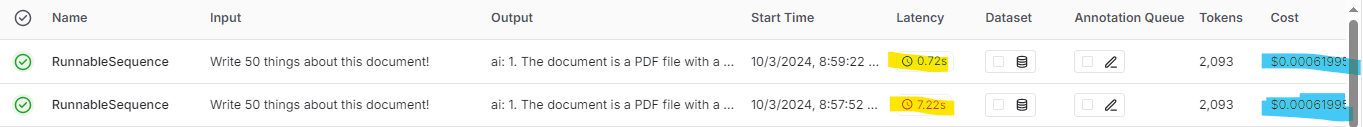

Latency is unquestionably much lower. However, what happened with the cost estimation? LangChain/LangSmith is confused!

##### Random questions dataset example

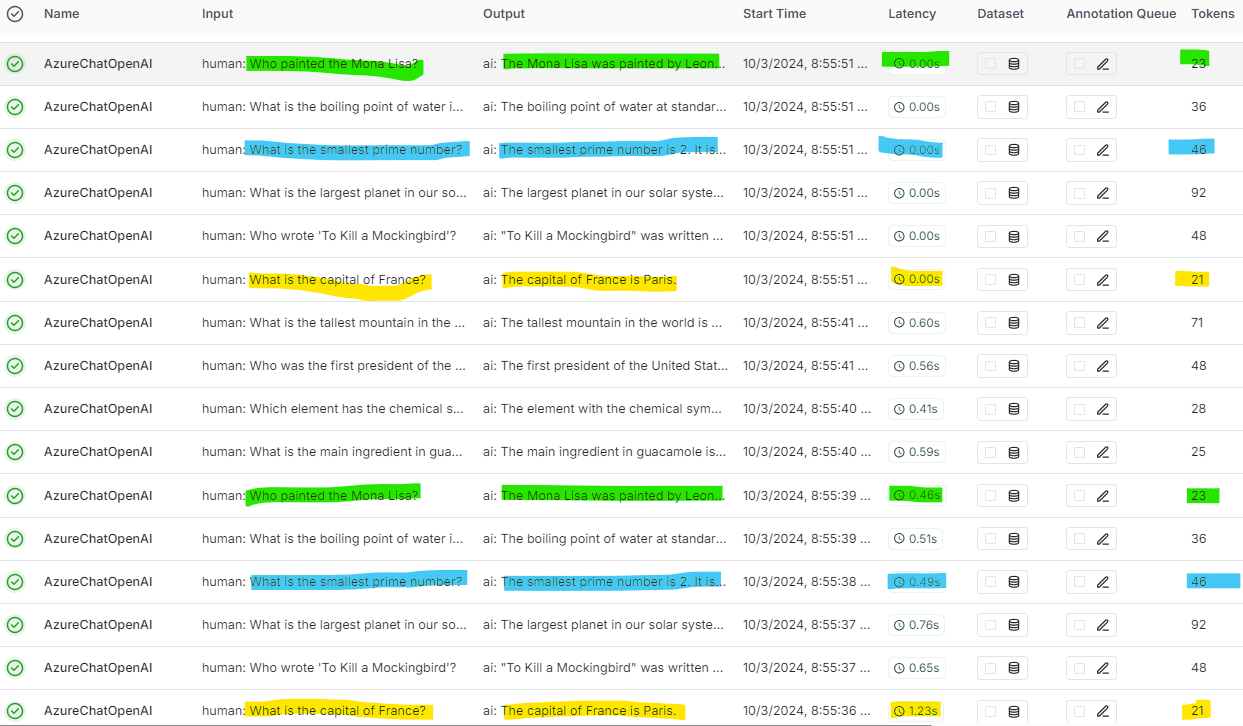

As we can see:
- we have exactly same questions cached and uncached
- answers to those questions are exactly same as they match in text verbatim and also in token length
- latency difference is tremendous, as by human standards cached asnwers are immediate and happens in less than a blink of an eye

## Embedding models experiment

Null hypothesis: cosine similiarity is the same between text-embedding-ada-002 version 1 and text-embedding-ada-002 version 2

Alternative hypothesis: cosine similiarity is not equal one.

In [4]:
ada_v1 = AzureOpenAIEmbeddings(azure_deployment="text-embedding-ada-002-1")
ada_v2 = AzureOpenAIEmbeddings(azure_deployment="text-embedding-ada-002")

In [78]:
!pip install scikit-learn

  Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl.metadata (13 kB)
  Using cached scipy-1.14.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl (11.0 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.14.1-cp312-cp312-win_amd64.whl (44.5 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


#### Let's run a simple test

In [79]:
from sklearn.metrics.pairwise import cosine_similarity

# Get embeddings for the same query using both versions
embedding_v1 = ada_v1.embed_query("What is the capital of France?")
embedding_v2 = ada_v2.embed_query("What is the capital of France?")

# Calculate cosine similarity
similarity = cosine_similarity([embedding_v1], [embedding_v2])

print(f"Cosine similarity between embeddings from ada_v1 and ada_v2: {similarity[0][0]}")

Cosine similarity between embeddings from ada_v1 and ada_v2: 0.00769668078914199


In [5]:
king = ada_v1.embed_query("king")
man = ada_v1.embed_query("man")

In [8]:
king[:10]

[-0.008050450123846531,
 -0.015901802107691765,
 0.06911268085241318,
 -0.033898454159498215,
 -0.022714387625455856,
 -0.006751990411430597,
 0.010058734565973282,
 0.042693354189395905,
 -0.020204031839966774,
 0.004981757141649723]

In [9]:
man[:10]

[0.015348359942436218,
 -0.005946621298789978,
 0.03889176994562149,
 -0.01376838143914938,
 -0.01005282811820507,
 -0.019411161541938782,
 0.015695607289671898,
 0.042954571545124054,
 0.007804397959262133,
 0.004527245182543993]

In [16]:
import numpy as np

# Calculate the difference between the embeddings
difference = np.array(king) - np.array(man)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
similarity = cosine_similarity([king], [man])

In [12]:
similarity

array([[0.77560591]])

In [13]:
queen = ada_v1.embed_query("queen")
woman = ada_v1.embed_query("woman")

In [17]:
new_vector = np.array(woman) + difference

In [19]:
cosine_similarity([queen], [new_vector])

array([[0.85253272]])

In [ ]:
new_vector = np.array(woman) + difference

In [14]:
cosine_similarity([queen], [woman])

array([[0.82179116]])

In [83]:
embedding_v2[:10]

[0.024523556232452393,
 -0.011138465255498886,
 -0.0013015911681577563,
 -0.025255601853132248,
 -0.01755649410188198,
 0.015562297776341438,
 -0.015814727172255516,
 -0.006733565125614405,
 0.001610028906725347,
 -0.03445667028427124]

In [85]:
# Calculate cosine similarity
similarity = cosine_similarity([embedding_v1], [embedding_v1])

print(f"Cosine similarity between embeddings from ada_v1 and ada_v2: {similarity[0][0]}")

Cosine similarity between embeddings from ada_v1 and ada_v2: 1.0000000000000007


In [86]:
# Calculate cosine similarity
similarity = cosine_similarity([embedding_v2], [embedding_v2])

print(f"Cosine similarity between embeddings from ada_v1 and ada_v2: {similarity[0][0]}")

Cosine similarity between embeddings from ada_v1 and ada_v2: 1.0000000000000007


In [87]:
for question in questions:
    embedding_v1 = ada_v1.embed_query(question)
    embedding_v2 = ada_v2.embed_query(question)

    # Calculate cosine similarity
    similarity = cosine_similarity([embedding_v1], [embedding_v2])

    print(f"Cosine similarity between embeddings from ada_v1 and ada_v2: {similarity[0][0]}")

Cosine similarity between embeddings from ada_v1 and ada_v2: 0.00769668078914199
Cosine similarity between embeddings from ada_v1 and ada_v2: -0.011473943577060958
Cosine similarity between embeddings from ada_v1 and ada_v2: -0.022089993213592042
Cosine similarity between embeddings from ada_v1 and ada_v2: -0.03736920895180937
Cosine similarity between embeddings from ada_v1 and ada_v2: -0.026771521022255208
Cosine similarity between embeddings from ada_v1 and ada_v2: -0.010968601468341088
Cosine similarity between embeddings from ada_v1 and ada_v2: -0.043372897333191066
Cosine similarity between embeddings from ada_v1 and ada_v2: -0.017070201232153484
Cosine similarity between embeddings from ada_v1 and ada_v2: -0.020034082562977104
Cosine similarity between embeddings from ada_v1 and ada_v2: 0.012193550614419343


#### What the ...?

This simple experiment showed that different versions of the same embedding model have absolutely different vector space representation where the same vectors are almost orthogonal!

The implicaitons of this are huge:
- Your app will break if your deployment in Azure OpenAI is set to default and it will default to a new version. It will mean that your query is using one version while your database has another version.
- You will have to stick to a specific version to make sure nothing breaks.
- If your version is depricated, you are in trouble.